In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
customers = pd.read_csv(r"C:\Users\ADMIN\Downloads\Customers.csv")
transactions = pd.read_csv(r"C:\Users\ADMIN\Downloads\Transactions.csv")

In [3]:
merged_data = pd.merge(transactions, customers, on="CustomerID", how="inner")

In [4]:
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
merged_data['SignupDate'] = pd.to_datetime(merged_data['SignupDate'])

In [5]:
current_date = datetime.now()

In [6]:
customer_features = merged_data.groupby('CustomerID').agg({
    'TransactionDate': [
        lambda x: (current_date - x.max()).days,  # Recency
        'count'                                  # Frequency
    ],
    'TotalValue': 'sum',                        # Monetary Value
    'SignupDate': lambda x: (current_date - x.min()).days  # Tenure
})

In [7]:
customer_features.columns = ['Recency', 'Frequency', 'Monetary', 'Tenure']
customer_features.reset_index(inplace=True)

In [8]:
region_encoded = pd.get_dummies(merged_data[['CustomerID', 'Region']], columns=['Region'])
region_aggregated = region_encoded.groupby('CustomerID').sum()

In [9]:
customer_features = pd.merge(customer_features, region_aggregated, on='CustomerID', how='left')

In [10]:
X = customer_features.drop(columns=['CustomerID'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
dbi_scores = []
kmeans_models = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    # Calculate Davies-Bouldin Index for Each k
    dbi = davies_bouldin_score(X_scaled, labels)
    dbi_scores.append(dbi)
    kmeans_models.append((k, kmeans, labels))

In [13]:
optimal_k = np.argmin(dbi_scores) + 2
optimal_model = kmeans_models[optimal_k - 2]

In [14]:
optimal_labels = optimal_model[2]

In [15]:
silhouette = silhouette_score(X_scaled, optimal_labels)

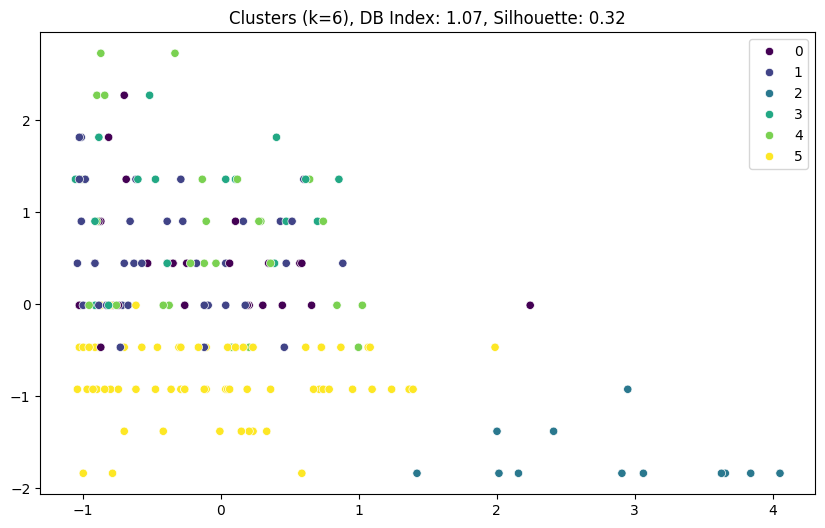

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=optimal_labels, palette='viridis')
plt.title(f"Clusters (k={optimal_k}), DB Index: {dbi_scores[optimal_k-2]:.2f}, Silhouette: {silhouette:.2f}")
plt.show()

In [17]:
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {dbi_scores[optimal_k-2]:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")


Optimal Number of Clusters: 6
Davies-Bouldin Index: 1.07
Silhouette Score: 0.32
